## Introduction

Project Mission - 

The increasing number of criminal incidents in the last couple of days in the United States has been a driving factor
for us to select this topic. We have identified this dataset as we plan on finding some of the root causes of what the 
numbers from these datasets show the relationships between demographic data and criminal. We are planning to start 
with finding the average of criminal offense region wise and then we are merging another dataset and will be cleaning 
data as part of our warm up question. With that completed, our next attempt would be towards finding the influential 
factors that contribute towards the crime that happen. Finally, our stretch question will be to utilize our analysis 
to implement additional libraries or technologies in analysis data from demographic dataset as well as the weather. 
To achieve the purpose of building analysis model, we could explore the statistic models, which is a Python module.


Contributors -
Ananya Mishra
Arjun Berry
Jayanti Trivedi
Tianzhu Wang
Xinying Du


Duration - July 2016 - August 2016



## Import the libraries

In [1]:
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import statsmodels.formula.api as sm
import numpy as np
import datetime
from pandas_datareader import data
from pandas_datareader import wb
import seaborn as sns
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import plotly.plotly as py
# Cufflinks binds plotly to pandas dataframes in IPython notebook.
import cufflinks as cf
#Below commands for converting the numerical values containing comma(,) in numbers to float64
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [2]:
#%matplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Function to convert columns to numeric data

In [3]:
def convert_numeric(crime_data,col_name):
    crime_data[col_name]=crime_data[col_name].convert_objects(convert_numeric=True)
    return crime_data

## Function to format crime data

In [4]:
def format_crime_data(crime_data):
    crime_data=crime_data.rename(columns=lambda x: x.strip())
    crime_data=crime_data.fillna(0)
    columns_list= crime_data.columns.tolist()
    for column in columns_list:
        if column not in (['State','County']):
            for element in crime_data[column]:
                element = pd.to_numeric(element)
    crime_data['Rape']=crime_data['Rape (revised definition)']+crime_data['Rape (legacy definition)']
    crime_data['sum_of_crimes']=crime_data['Violent Crime']+crime_data['Murder and nonnegligent manslaughter']+\
    crime_data['Rape']+crime_data['Robbery']+crime_data['Aggravated assault']+crime_data['Poverty Crime']+\
    crime_data['Burglary']+crime_data['Larceny-theft']+crime_data['Motor vehicle theft']+crime_data['Arson3']
    return crime_data

## Function to add county code to crime and police data

In [5]:
def add_county_code(df):
    # format df to prepare for merge
    df['State']=df['State'].str.split('-').str.get(0).str.strip().str.lower()
    df['County']=df['County'].str.lower()+' county'
    
    # add state abbreviation to df based on State name
    ab_states=pd.read_csv('USStates.txt',header=None,names=['State','ab','area','pop'])
    ab_states['State']=ab_states['State'].str.lower()
    df=df.merge(ab_states)
    
    # add county code based on the state abb and county name
    county_code = pd.read_csv('national_county.txt',header=None, names=['ab','c1','c2','County','H'],dtype=str)
    county_code['code']=county_code['c1']+county_code['c2']
    county_code['County']=county_code['County'].str.lower()
    df=pd.merge(df, county_code, on=['County','ab'],how='left')
    return df

## Read Data Files

In [6]:
# read crime data and formating crime data
crime_data = pd.read_csv('CrimeDate2014_Updated.csv',skiprows = 4,skip_footer = 8,thousands=',',na_values=['0',0,' '], engine='python')
crime_data.columns = ['State', 'County', 'Violent Crime' , 'Murder and nonnegligent manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated assault', 'Poverty Crime', 'Burglary', 'Larceny-theft','Motor vehicle theft', 'Arson3']
crime_data = format_crime_data(crime_data)
crime_data = add_county_code(crime_data)

# read police data and formating police data
police_data = pd.read_csv('Police_2014.csv',skiprows=3,skip_footer=1,thousands=',', engine='python')
police_data = add_county_code(police_data)
police_data = police_data.ix[:, ['code', 'police']]
police_data.columns = ['code', 'police']

# read other predictor variables and save useful columns
population = pd.read_csv('PopulationEstimates.csv', usecols=[0,3], skiprows=2,thousands=',',dtype=str,na_values=['0',0,' '])
population.columns = ['code', 'population']
#population['population'] = population['population'] / 1000 

#
unem = pd.read_csv('Unemployment.csv',usecols =[0,3], header=0,skiprows=6,thousands=',',dtype=str,na_values=['0',0,' '])
unem.columns = ['code', 'unem']

#
poverty = pd.read_csv('PovertyEstimates.csv',usecols = [0,3],header=0,skiprows=2,thousands=',',dtype=str,na_values=['0',0,' '])
poverty.columns = ['code', 'poverty']
#poverty['poverty'] = poverty['poverty'] / 1000

#
education = pd.read_csv('Education.csv',usecols=[0,1],header=0,skiprows=4,thousands=',',dtype=str,na_values=['0',0,' '])
education.columns = ['code', 'education']

## Merge all data files together

In [13]:
crime = pd.merge(crime_data, police_data, on='code', how='left')\
    .merge(population, on='code', how='left')\
    .merge(unem, on='code', how='left')\
    .merge(poverty, on='code', how='left')\
    .merge(education, on='code', how='left')

crime=crime.dropna()
crime=crime[crime['sum_of_crimes']!=0]

pop=crime['population'].str.replace(',','').astype(float)
edu=crime['education'].str.replace(',','').astype(float)
pov=crime['poverty'].str.replace(',','').astype(float)

crime.head()

,State,County,Violent Crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Poverty Crime,Burglary,...,pop,c1,c2,H,code,police,population,unem,poverty,education
34191,florida,alachua county,572.0,1.0,50.0,0.0,78.0,443.0,2086.0,634.0,...,15313000,12,001,H1,12001,568.0,"256,518",5.2,"52,756",8.2
34235,florida,calhoun county,17.0,0.0,3.0,0.0,0.0,14.0,76.0,30.0,...,15313000,12,013,H1,12013,29.0,"14,511",6.9,"2,800",26.7
34256,georgia,bartow county,328.0,2.0,0.0,21.0,24.0,281.0,2367.0,638.0,...,7637000,13,015,H1,13015,228.0,"101,795",7.1,"14,398",18.7
65187,georgia,baldwin county,189.0,1.0,0.0,4.0,3.0,181.0,600.0,137.0,...,7637000,13,009,H1,13009,120.0,"45,822",8.7,"11,809",17.5
71430,idaho,ada county,184.0,0.0,65.0,0.0,2.0,117.0,843.0,191.0,...,1290000,16,001,H1,16001,425.0,"426,847",4.2,"48,083",6.2


In [14]:
# Converting the comma in population figure to a float64 quantity
crime[['population']] = crime[['population']].applymap(atof)

In [15]:
# Converting the comma in population figure to a float64 quantity
crime[['poverty']] = crime[['poverty']].applymap(atof)

In [16]:
# Converting the comma in population figure to a float64 quantity
crime[['education']] = crime[['education']].applymap(atof)

In [17]:
crime.dtypes

State                                    object
County                                   object
Violent Crime                           float64
Murder and nonnegligent manslaughter    float64
Rape (revised definition)               float64
Rape (legacy definition)                float64
Robbery                                 float64
Aggravated assault                      float64
Poverty Crime                           float64
Burglary                                float64
Larceny-theft                           float64
Motor vehicle theft                     float64
Arson3                                  float64
Rape                                    float64
sum_of_crimes                           float64
ab                                       object
area                                      int64
pop                                       int64
c1                                       object
c2                                       object
H                                       

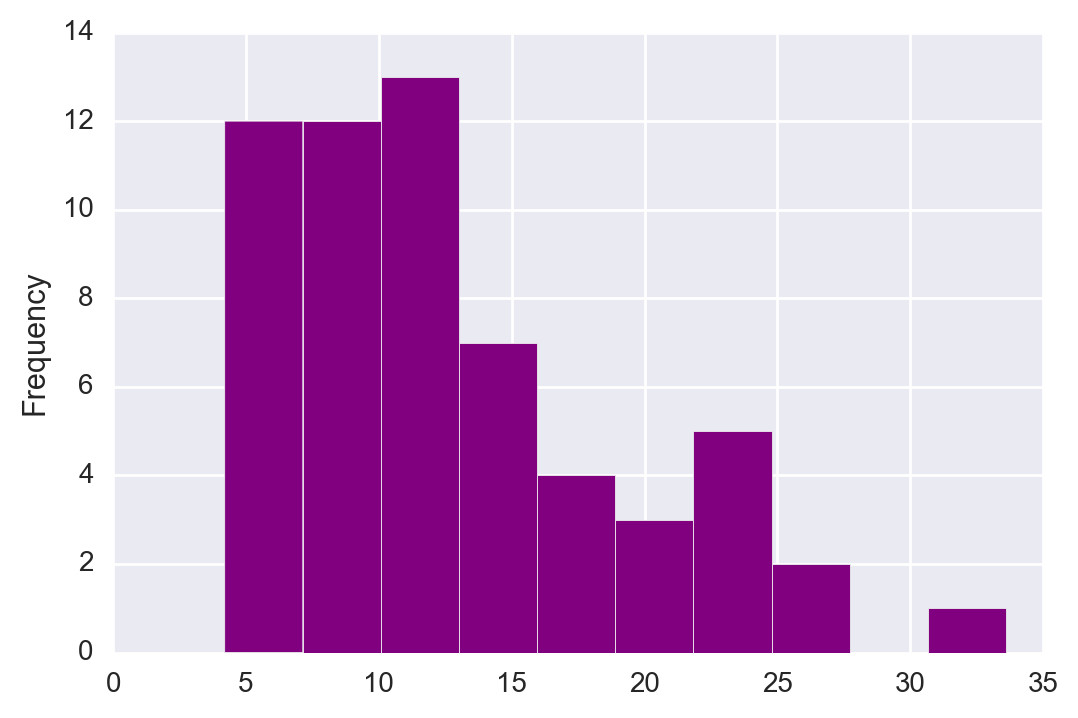

In [18]:
crime['education'].plot.hist(color = 'purple')

In [29]:
crime['education'].head()

34191     8.2
34235    26.7
34256    18.7
65187    17.5
71430     6.2
Name: education, dtype: float64

# Time for Analysis

## Which state has the highest criminal activities in US ?

In [19]:
sum_by_state=crime.groupby('State').sum()['sum_of_crimes']
highest=sum_by_state[sum_by_state==sum_by_state.max()]
print('{} has highest criminal activities that is {} crimes in total in 2014.'.format(str.capitalize(highest.index.values[0]),int(highest[0])))

Georgia has highest criminal activities that is 6968 crimes in total in 2014.


## The top 3 states with highest average criminal offenses.

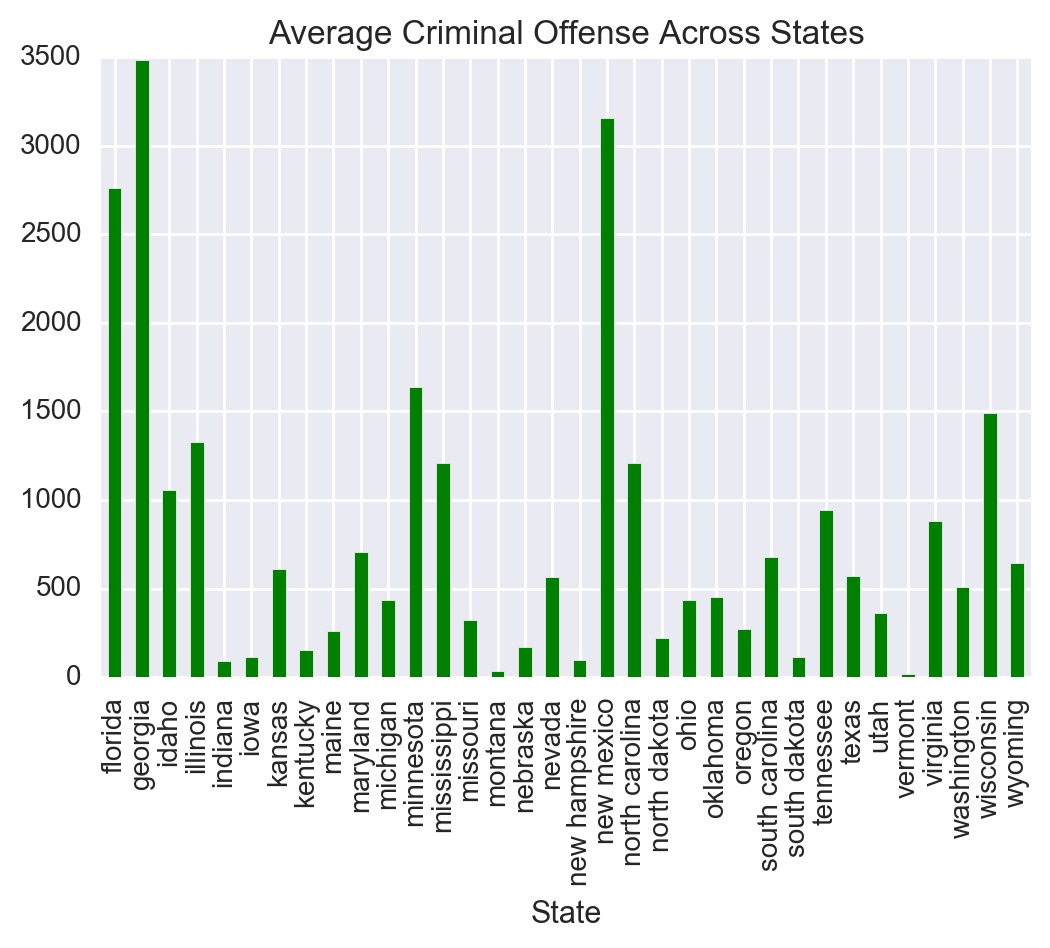

In [33]:
all_by_state=crime.groupby('State').mean()['sum_of_crimes']
all_by_state.plot(kind='bar', title= 'Average Criminal Offense Across States', color = "green")

In [34]:
top3_avg_crime = all_by_state.sort_values(ascending= False).head(3)
# converting new mexico to string and using title function to capitalize it to New Mexico
print("The top 3 states with highest average are : {} | {} | {} in this particular order.".format(str.capitalize(top3_avg_crime.index.values[0]), str(top3_avg_crime.index.values[1]).title(), str.capitalize(top3_avg_crime.index.values[2])))

The top 3 states with highest average are : Georgia | New Mexico | Florida in this particular order.


##  The top 3 states with the highest burglary crime rate. 

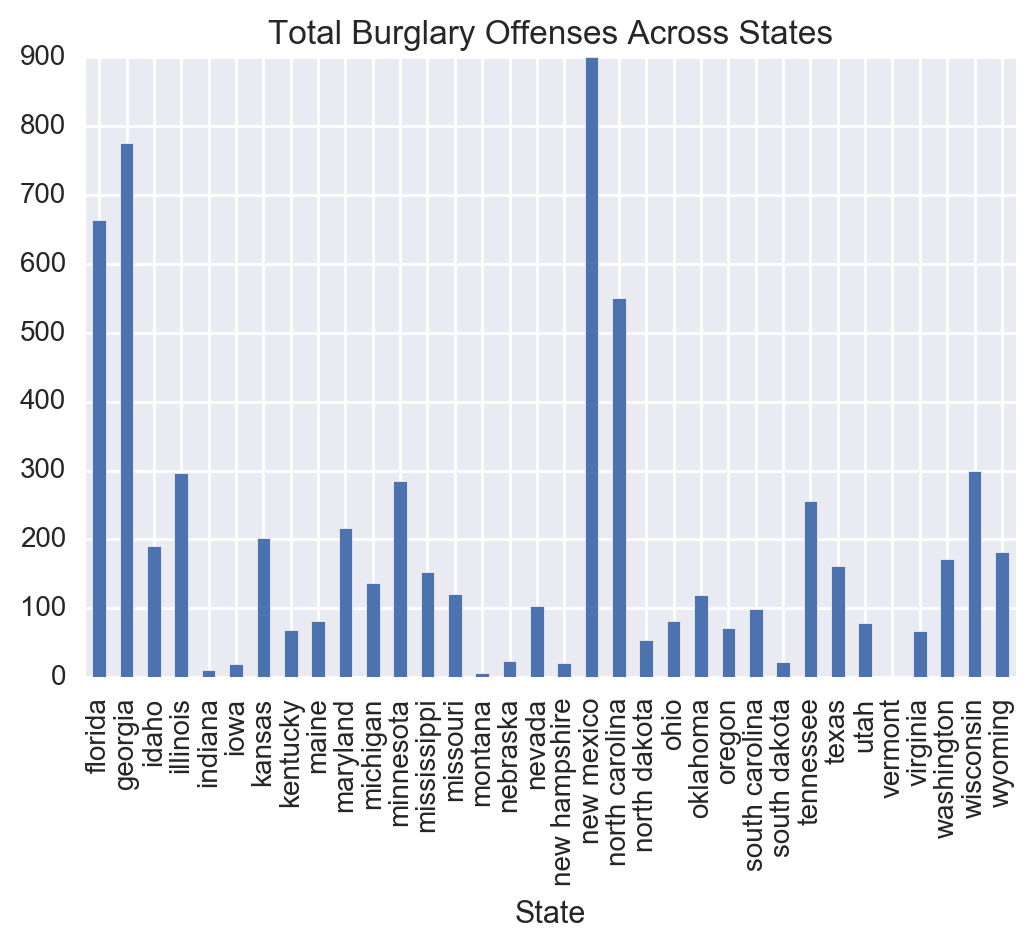

In [38]:
bur_by_state=DataFrame(crime.groupby('State').sum()['Burglary'])
bur_by_state.plot(kind='bar', title= "Total Burglary Offenses Across States", legend=False)

## Top 3 States with highest Burglary Crime Rate

In [45]:
top3_burglary = bur_by_state['Burglary'].sort_values(ascending= False).head(3)
# converting new mexico to string and using title function to capitalize it to New Mexico
print("The top 3 states with highest burglary are : {} | {} | {} in this\nparticular order.".format(str(top3_burglary.index.values[0]).title(), str(top3_burglary.index.values[1]).title(), str(top3_burglary.index.values[2]).title()))

The top 3 states with highest burglary are : New Mexico | Georgia | Florida in this
particular order.


## Are the top 3 states having the highest violent crime rate same as the ones with Burglary crimes?

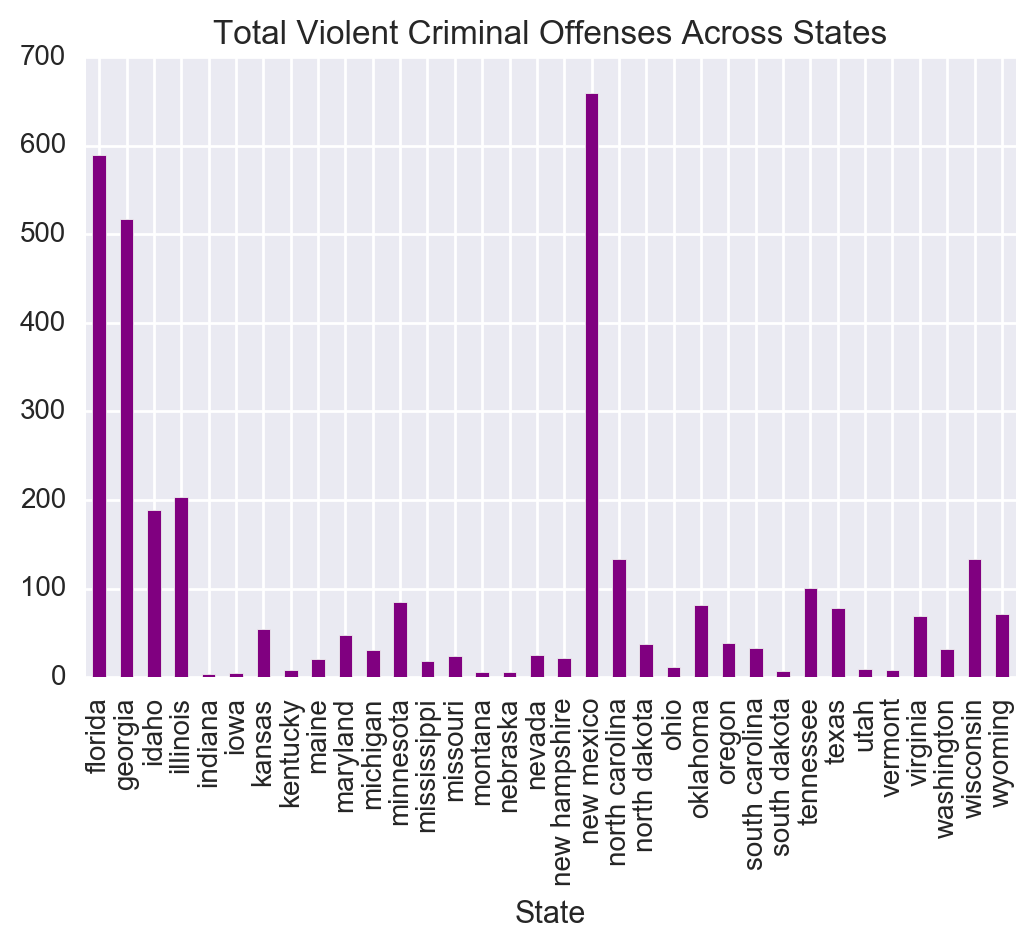

In [47]:
vio_by_state=DataFrame(crime.groupby('State').sum()['Violent Crime'])
vio_by_state.plot(kind='bar', title= "Total Violent Criminal Offenses Across States", color ='purple', legend=False)

In [48]:
top3_violent = vio_by_state['Violent Crime'].sort_values(ascending= False).head(3)
# converting new mexico to string and using title function to capitalize it to New Mexico
print("The top 3 states with highest burglary are : {} | {} | {} in this\nparticular order.".format(str(top3_violent.index.values[0]).title(), str(top3_violent.index.values[1]).title(), str(top3_violent.index.values[2]).title()))

The top 3 states with highest burglary are : New Mexico | Florida | Georgia in this
particular order.


# Indeed New Mexico, Florida and Georgia are the ones with most criminal activities.

## Top 10 states with highest crime rate

## State having the maximum presence in top 10 counties of total crime.

In [49]:
to_sort=DataFrame(crime['sum_of_crimes'])
to_sort['State']=crime['State']
to_sort['county']=crime['code']

top10=to_sort.sort_values('sum_of_crimes',ascending=0).head(10)
result=top10.groupby('State').count()
max_count=result['sum_of_crimes'].max()
max_state=result[result['sum_of_crimes']==max_count].index.values[0]
print('The one has most of the counties in top 10 are from {}.'.format(str.capitalize(max_state)))

The one has most of the counties in top 10 are from Georgia.


# Let's then dive into finding factors that affect crime rate. 

## Is there any significant influence of population, education level, poverty, unemployment as well police staff number on the crime rate of a county?

In [50]:
# add log to crime
crime['sum_of_crimes_log']=crime['sum_of_crimes'].astype(float).apply(np.log10)
crime['police_log']=crime['police'].astype(float).apply(np.log10)
crime['population_log']=pop.apply(np.log10)
crime['poverty_log']=pov.apply(np.log10)
crime['education_log']=edu.apply(np.log10)

# perform regression
result = sm.ols(formula="sum_of_crimes_log ~ police_log+population_log+poverty_log+education_log", data=crime).fit()
print(result.params)
print(result.summary())


Intercept         1.012689
police_log        0.861773
population_log   -0.495484
poverty_log       0.484285
education_log     0.542138
dtype: float64
                            OLS Regression Results                            
Dep. Variable:      sum_of_crimes_log   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     38.14
Date:                Tue, 14 Mar 2017   Prob (F-statistic):           3.89e-15
Time:                        18:42:01   Log-Likelihood:                -15.121
No. Observations:                  59   AIC:                             40.24
Df Residuals:                      54   BIC:                             50.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|  

1.0236632633831952e-15

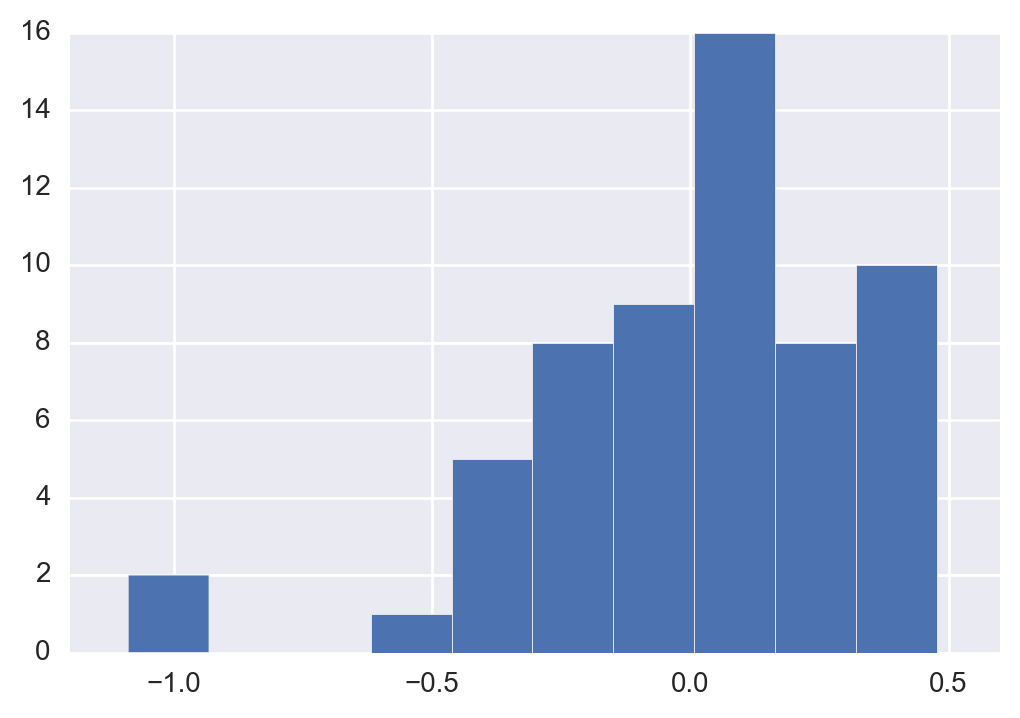

In [54]:
plt.hist(result.resid)
result.resid.mean()

## Element	Description
#### Dep. Variable - sum_of_crimes_log(Total crimes) is the response in the model

#### Model - Ordinary Least Squares model is being used in the fit

#### Method - The parameters of the model were calculated by Least Squares method

#### No. Observations - The number of observations used here are 59

#### DF Residuals - Degrees of freedom of the residuals here is 54 and is calculates by the following - 

##### Number of observations – number of parameters [ 59 - 5 ] (As there are 4 independent variables + 1 constant term) 

#### DF Model - Number of parameters in the model are 4 (police, population, poverty and education)

# The right part of the first table shows the goodness of fit

## Element	Description

#### R-squared - 73% is the coefficient of determination. A statistical measure of how well the regression line approximates the real data points. This means that 73% of Total Crime rate is explained by police, population, poverty and education. 

#### Adj. R-squared - 71%. This is  the above value adjusted based on the number of observations and the degrees-of-freedom of the residuals

#### F-statistic - 38.14.  A measure how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals

Prob (F-statistic)	The probability that you would get the above statistic, given the null hypothesis that they are unrelated
Log-likelihood	The log of the likelihood function.
AIC	The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model.
BIC	The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters.
The second table reports for each of the coefficients
Description
The name of the term in the model
coef	The estimated value of the coefficient
std err	The basic standard error of the estimate of the coefficient. More sophisticated errors are also available.
t	The t-statistic value. This is a measure of how statistically significant the coefficient is.
P > |t|	P-value that the null-hypothesis that the coefficient = 0 is true. If it is less than the confidence level, often 0.05, it indicates that there is a statistically significant relationship between the term and the response.
[95.0% Conf. Interval]	The lower and upper values of the 95% confidence interval
Finally, there are several statistical tests to assess the distribution of the residuals
Element	Description
Skewness	A measure of the symmetry of the data about the mean. Normally-distributed errors should be symmetrically distributed about the mean (equal amounts above and below the line).
Kurtosis	A measure of the shape of the distribution. Compares the amount of data close to the mean with those far away from the mean (in the tails).
Omnibus	D’Angostino’s test. It provides a combined statistical test for the presence of skewness and kurtosis.
Prob(Omnibus)	The above statistic turned into a probability
Jarque-Bera	A different test of the skewness and kurtosis
Prob (JB)	The above statistic turned into a probability
Durbin-Watson	A test for the presence of autocorrelation (that the errors are not independent.) Often important in time-series analysis
Cond. No	A test for multicollinearity (if in a fit with multiple parameters, the parameters are related with each other).
As a final note, if you don’t want to include a constant term in your model, you can exclude it using the minus operator.

### Our regression results showed, that there exists significant relationship of number of crimes with police enforcement, population, poverty and education level. Among all these predictors, number of police enforcement has the highest relationship with crime. From this we can infer, that for each percent increase in log of police enforcement variable, log of total crime increases by 0.82 over and above the presence of other predictors in the model. Education and poverty also have positive relationship with total crime. However, the relationship between population and crime is negative, meaning that keeping all the other predictors constant in the model, the more crowded an area is, the safer it is. The R2 for our model is 0.65. In other words, the four predictors of our model explain around 65% of variance in total crime.


## How does the parole data influence the number of violent crimes in California?

In [83]:
# read original crime data of California
crime_ca_data = pd.read_csv('Crime Ca 1985~2005.csv', skiprows = 4,index_col = 0)
crime_ca_data = crime_ca_data.T
crime_ca_data.index = crime_ca_data.index.astype(int)

In [84]:
crime_ca_data.columns = crime_ca_data.columns.map(lambda x : x.replace(' ','_'))
#if isinstance(x,(str,unicode))else x)

In [85]:
crime_ca_data = crime_ca_data.ix[:,'Violent_Crimes': 'Rape']

In [86]:
# population data
start = datetime.datetime(1985,1,1)
end = datetime.datetime(2015,1,1)
pop_data = data.DataReader("CAPOP", "fred", start, end).resample('A-DEC').mean()
pop_data.index = pop_data.index.year.astype(int)

ConnectionError: HTTPConnectionPool(host='research.stlouisfed.org', port=80): Max retries exceeded with url: /fred2/series/CAPOP/downloaddata/CAPOP.csv (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x11d629eb8>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [ ]:
# prison and parole data
prison = pd.read_csv('prison_population.csv',index_col = 0)

In [ ]:
# poverty data
poverty = pd.read_csv('poverty - ca.csv',index_col = 0)

In [ ]:
# merge all ariables into dataframe crime_ca
crime_ca = pd.merge(crime_ca_data, prison, left_index=True, right_index = True)\
    .merge(pop_data, left_index=True, right_index = True)\
    .merge(poverty, left_index=True, right_index = True)\
    crime_ca = crime_ca.dropna()

In [ ]:
# add log to crime
crime_ca['Violent_Crimes_log']=crime_ca['Violent_Crimes'].astype(float).apply(np.log10)
crime_ca['Rape_log']=crime_ca['Rape'].astype(float).apply(np.log10)
crime_ca['Homicide_log']=crime_ca['Homicide'].astype(float).apply(np.log10)

In [ ]:
crime_ca['CAPOP_log']=crime_ca['CAPOP'].astype(float).apply(np.log10)
crime_ca['prison_log']=crime_ca['prison'].astype(float).apply(np.log10)
crime_ca['parole_log']=crime_ca['parole'].astype(float).apply(np.log10)
crime_ca['poverty_log']=crime_ca['poverty'].astype(float).apply(np.log10)

In [82]:
# perform regression
result2 = sm.ols(formula="Violent_Crimes_log ~ CAPOP_log+ parole_log+poverty_log", data=crime_ca).fit()
print(result2.params)
print(result2.summary())

ConnectionError: HTTPConnectionPool(host='research.stlouisfed.org', port=80): Max retries exceeded with url: /fred2/series/CAPOP/downloaddata/CAPOP.csv (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x11d6376a0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [ ]:
crime_ca.head()

## Also how these factors if at all influence the Rape Crimes in California ?

In [ ]:
result3 = sm.ols(formula="Rape_log ~ CAPOP_log+ parole_log+poverty_log", data=crime_ca).fit()
print(result3.params)
print(result3.summary())

## And if these same factors influence the Homicide Crimes in California ?

In [ ]:
result4 = sm.ols(formula="Homicide_log ~ CAPOP_log+ parole_log+poverty_log", data=crime_ca).fit()
print(result4.params)
print(result4.summary())

# Let's see the correlation between various terms. 

## Correlation of Violent Crimes and Population in CA

In [ ]:
crime_ca.plot.scatter(x='CAPOP',y='Violent_Crimes', title = "Correlation between Population and Violent crimes in California")
sns.regplot(x="CAPOP", y="Violent_Crimes", data=crime_ca, order = 3, color= 'purple', truncate= True)
plt.xlim(26000,37700)
plt.ylim(100000,360000)
plt.xlabel('Population in CA')
plt.ylabel('Violent Crimes')

In [ ]:
crime_ca.head()

In [14]:
# Population is divide by 1000 to make scale it amongst other variables
crime_ca['population'] = crime['population'].apply(lambda x: float(x) / 1000)

## Correlation of Violent Crimes and Parole Volume in CA

In [ ]:
crime_ca.plot.scatter(x='parole',y='Violent_Crimes', title = "Correlation of Violent Crime and Parole Volume in CA")
sns.regplot(x="parole", y="Violent_Crimes", data=crime_ca, order = 2, color= 'black', truncate= True)
plt.xlim(28000,130000)
plt.ylim(150000,360000)
plt.xlabel('Parole in CA')
plt.ylabel('Violent Crimes')
#m, b = np.polyfit(crime_ca['parole'], crime_ca['Violent_Crimes'], 1)
#crime_ca.plot(x='parole', y = m*'parole' + b, '-g')

## Correlation of Violent Crimes with Poverty Volume in CA

In [ ]:
crime_ca.plot.scatter(x='poverty',y='Violent_Crimes', title = "Correlation of Violent Crimes with Poverty Volume in CA")
sns.regplot(x="poverty", y="Violent_Crimes", data= crime_ca, marker = "^", color= 'green', truncate= True)
plt.xlim(3300,6200)
plt.ylim(150000,360000)
plt.xlabel('Poverty in CA')
plt.ylabel('Violent Crimes')

## Correlation of Violent Crimes with Prison in CA

In [ ]:
crime_ca.plot.scatter(x='prison',y='Violent_Crimes', title = "Correlation of Violent Crimes with Prison in CA")
sns.regplot(x="prison", y="Violent_Crimes", data=crime_ca, order = 2, color= 'blue', truncate= True)
plt.xlim(140,480)
plt.ylim(120000,360000)
plt.xlabel('Prison in CA')
plt.ylabel('Violent Crimes')

## Moving on to other aspects, that might be interesting, we would like to see how crime is being affected by various factors.

### Does Education impact Crimes in general ?

In [ ]:
crime[['education']] = crime[['education']].apply(pd.to_numeric)
crime.plot.scatter(x='education',y='sum_of_crimes', title  = 'Education Level')
sns.regplot(x="education", y="sum_of_crimes", data=crime, order=1, truncate= True)
plt.xlim(4,35)
plt.ylim(-500,5900)
plt.xlabel('Education')
plt.ylabel('Total Crimes')

In [ ]:
#Q2 sum_of_crimes ~ education
plt.figure()
crime[['education']] = crime[['education']].apply(pd.to_numeric)
f1=plt.subplot(231)
m, b = np.polyfit(crime['education'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='education',y='sum_of_crimes',ax=f1)
f1.set_title('Education Level')
f1.plot(crime['education'], m*crime['education'] + b, '-g')
sns.regplot(x="education", y="sum_of_crimes", data=crime)

### But what about Poverty ?

In [ ]:
#Q2 sum_of_crimes ~ poverty
f2=plt.subplot(232)
crime["poverty"] = crime["poverty"].str.replace(r'[,]', '').astype('float')
m, b = np.polyfit(crime['poverty'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='poverty',y='sum_of_crimes',ax=f2)
f2.set_title('Poverty Level')
f2.plot(crime['poverty'], m*crime['poverty'] + b, '-g')

### Population should definitely impact crimes. But does it ?

In [ ]:
#Q2 sum_of_crimes ~ population
f3=plt.subplot(233)
crime["population"] = crime["population"].str.replace(r'[,]', '').astype('float')
m, b = np.polyfit(crime['population'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='population',y='sum_of_crimes',ax=f3)
f3.set_title('Population')
f3.plot(crime['population'], m*crime['population'] + b, '-g')

### Umm .... Police ? 

In [ ]:
#Q2 sum_of_crimes ~ police
f4=plt.subplot(234)
m, b = np.polyfit(crime['police'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='police',y='sum_of_crimes',ax=f4)
f4.set_title('Police')
f4.plot(crime['police'], m*crime['police'] + b, '-g')

### How about Unemployment?

In [ ]:
#Q2 sum_of_crimes ~ unemployment
f5=plt.subplot(235)
crime["unem"] = crime["unem"].str.replace(r'[,]', '').astype('float')
m, b = np.polyfit(crime['unem'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='unem',y='sum_of_crimes',ax=f5)
f5.set_title('Umemployment')
f5.plot(crime['unem'], m*crime['unem'] + b, '-g')
plt.show()

# We would be now interested at looking at a bigger picture about crimes.

In [ ]:
"""
************************************** Extra Mapping states on the Maps ********************************************
"""
plt.figure()
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('states','states',drawbounds=True)

# population density by state from
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = 0; vmax = 450 # set range.
print(m.states_info[0].keys())
for shapedict in m.states_info:
    statename = shapedict['STATE_NAME']
    statenames.append(statename)

# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
seg = m.states[statenames.index('Texas')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('Florida')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('Georgia')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('Louisiana')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('South Carolina')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('Maryland')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('North Carolina')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('Virginia')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('Tennessee')]
poly = Polygon(seg, facecolor='yellow',edgecolor='yellow')
ax.add_patch(poly)
seg = m.states[statenames.index('Washington')]
poly = Polygon(seg, facecolor='yellow',edgecolor='yellow')
ax.add_patch(poly)
seg = m.states[statenames.index('Montana')]
poly = Polygon(seg, facecolor='yellow',edgecolor='yellow')
ax.add_patch(poly)

plt.show()

In [ ]:
! pip install cufflinks